## Cargar datos

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('once')

In [2]:
serie_GWh = pd.read_csv('../data/datos_Demanda_EU27_GWh.csv', index_col=0, parse_dates=True)['EU27']
# poner el índice con frecuencia diaria
serie_GWh = serie_GWh.asfreq('D')

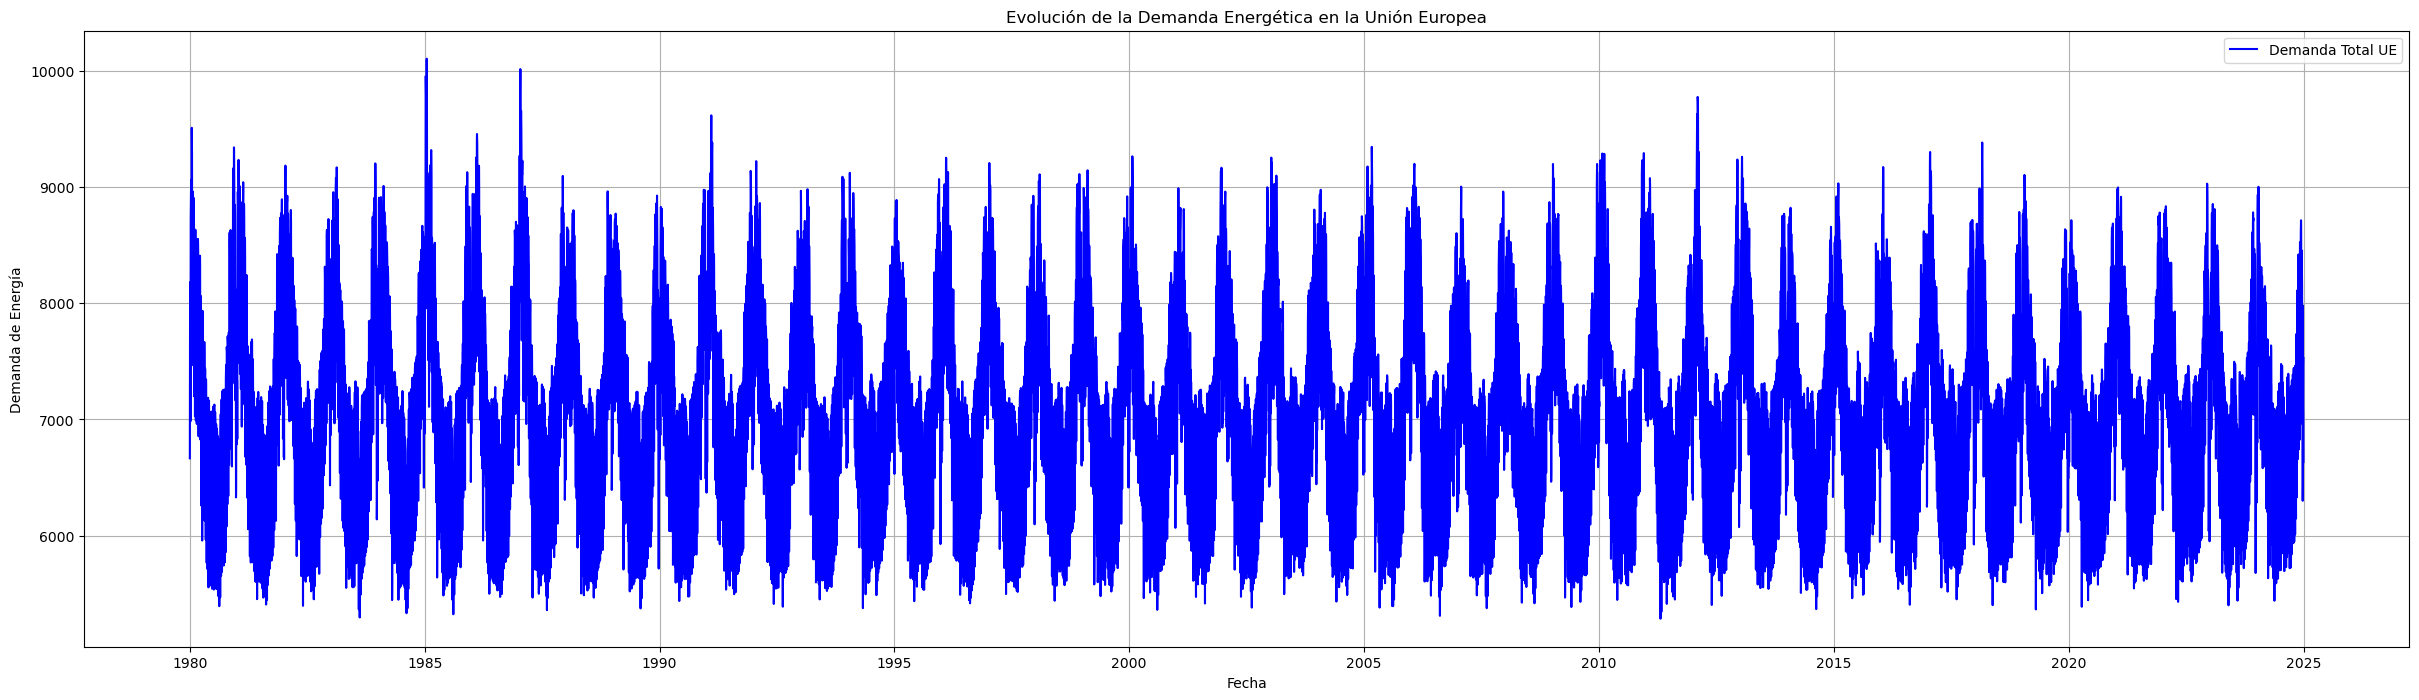

In [3]:
# Crear la figura y el gráfico
plt.figure(figsize=(30, 8))
plt.plot(serie_GWh.index, serie_GWh.values, label="Demanda Total UE", color="blue")

# Etiquetas y título
plt.xlabel("Fecha")
plt.ylabel("Demanda de Energía")
plt.title("Evolución de la Demanda Energética en la Unión Europea")
plt.legend()
plt.grid()

# Mostrar el gráfico
plt.show()

## Características Serie Temporal

### Estacionariedad de la serie

#### KPSS

In [4]:
from pmdarima.arima.utils import ndiffs

# Calcular el número óptimo de diferenciaciones con el test de KPSS
d_optimo = ndiffs(serie_GWh, test='kpss')
print(f"Valor óptimo de d según KPSS: {d_optimo}")

Valor óptimo de d según KPSS: 0


#### ADF
ADF (Augmented Dickey-Fuller) test is a statistical significance test which means the test will give results in hypothesis tests with null and alternative hypotheses. As a result, we will have a p-value from which we will need to make inferences about the time serie_GWhs, whether it is stationary or not.

In [5]:
from statsmodels.tsa.stattools import adfuller

# Aplicar la prueba de Dickey-Fuller Aumentado
result = adfuller(serie_GWh)

# Mostrar resultados
print(f"Estadístico de prueba ADF: {result[0]}")
print(f"p-valor: {result[1]}")

# Ver si la serie_GWh es estacionaria
if result[1] < 0.05:
    print("La serie_GWh es estacionaria (no necesita diferenciación, d=0).")
else:
    print("La serie_GWh no es estacionaria (se recomienda diferenciación, d=1).")

Estadístico de prueba ADF: -10.55964083039971
p-valor: 7.788327867095203e-19
La serie_GWh es estacionaria (no necesita diferenciación, d=0).


In [6]:
dftest = adfuller(serie_GWh, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -10.55964083039971
2. P-Value :  7.788327867095203e-19
3. Num Of Lags :  43
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 16393
5. Critical Values :
	 1% :  -3.430748970552628
	 5% :  -2.8617163288251066
	 10% :  -2.5668638553866665


### Autocorrelación
La autocorrelación se refiere al grado de correlación entre las mismas variables entre dos intervalos de tiempo sucesivos. Mide cómo la versión rezagada (lagged) del valor de una variable está relacionada con la versión original en una serie_GWh temporal.  
  
Se puede ver claramente que la serie_GWh tiene una clara **estacionalidad**. Se ve una onda sinusoidal fuerte alrededor de cada +-400 lags.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

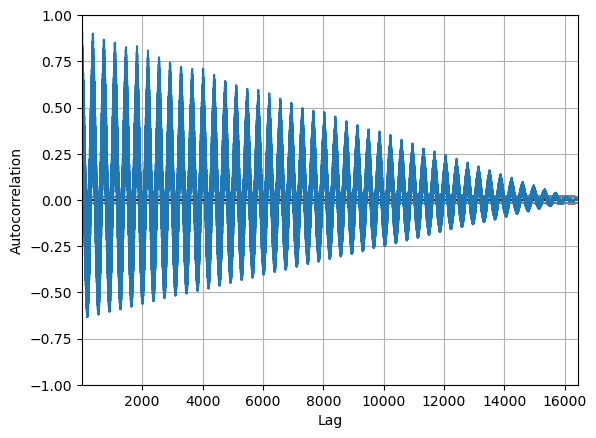

In [7]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(serie_GWh)

#### ACF
El gráfico ACF (Autocorrelation Function) muestra la correlación entre una serie_GWh temporal y una versión rezagada de sí misma.   
  
En este caso, el gráfico ACF disminuye exponencialmente, pero de forma sinusoidal. Esto puede indicar que la serie_GWh temporal es estacional.

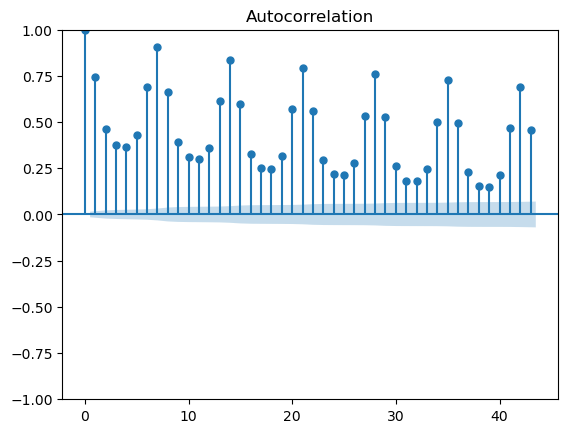

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(serie_GWh)
plt.show()

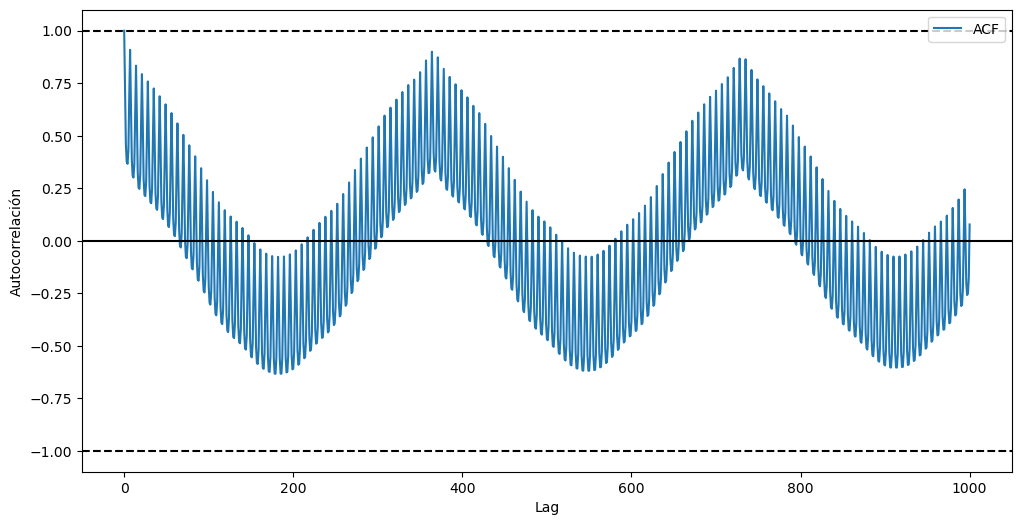

In [9]:
from statsmodels.tsa.stattools import acf

# Calcular ACF con más lags
acf_values = acf(serie_GWh, nlags=1000)

# Graficar la ACF
plt.figure(figsize=(12,6))
plt.plot(acf_values, label="ACF")

plt.xlabel("Lag")
plt.ylabel("Autocorrelación")
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='--')
plt.axhline(y=-1, color='black', linestyle='--')
plt.legend()
plt.show()

#### Periodicidad
Vamos a calcular el periodo estimado de la serie, usando la autocorrelación.  
  
``m=364`` periodicidad claramente aunal.

Picos detectados en gráfica ACF: [   7  364  728 1092 1463 1827]


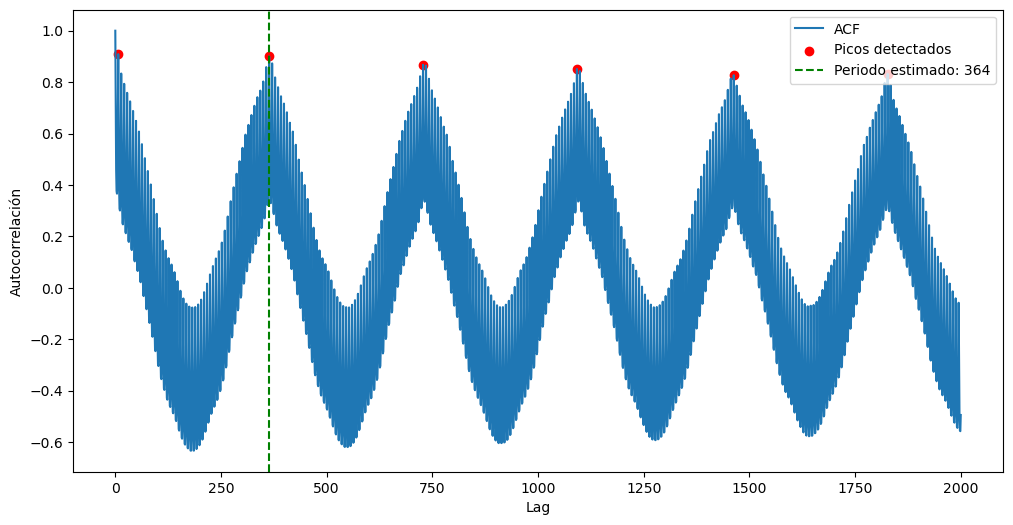

El período estacional estimado es aproximadamente 364 lags.


In [11]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Calcular ACF con más lags
acf_values = acf(serie_GWh, nlags=2000)

# Encontrar los picos con mejores criterios
peaks, _ = find_peaks(acf_values, height=0.3, distance=100, prominence=0.1)
print(f"Picos detectados en gráfica ACF: {peaks}")

# Calcular la distancia promedio entre picos significativos
peak_distances = np.diff(peaks)
periodo_estimado = int(np.mean(peak_distances)) if len(peak_distances) > 0 else None

# Graficar la ACF con los picos mejor detectados
plt.figure(figsize=(12,6))
plt.plot(acf_values, label="ACF")
plt.scatter(peaks, acf_values[peaks], color='red', label="Picos detectados")
if periodo_estimado:
    plt.axvline(periodo_estimado, color='green', linestyle='dashed', label=f'Periodo estimado: {periodo_estimado}')

plt.xlabel("Lag")
plt.ylabel("Autocorrelación")
plt.legend()
plt.show()

print(f"El período estacional estimado es aproximadamente {periodo_estimado} lags.")


#### PACF
El gráfico PACF (Partial Autocorrelation Function) muestra la correlación entre una serie_GWh temporal y una versión rezagada de sí misma después de eliminar los efectos de las observaciones intermedias.

En este caso, se puede ver una fuerte correlación con los primeros lags y luego un drástico desplome. Eso significa que **la parte AR de la serie_GWh temporal, tendrá un orden bajo** (menor de 10 seguro).

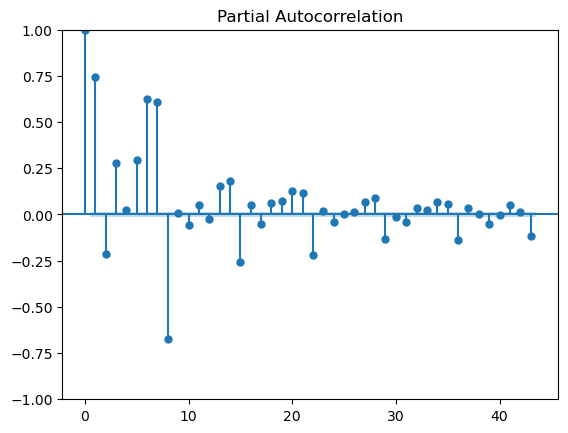

In [35]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(serie_GWh)
plt.show()

### prueba ranking lags ACF y PACF

Lags significativos en PACF (para p): 0     1.000000
1     0.744909
8     0.674161
6     0.627528
7     0.609532
5     0.296157
3     0.280447
15    0.256372
22    0.218740
2     0.212557
dtype: float64

Lags significativos en ACF (para q): 0       1.000000
7       0.908927
364     0.899888
371     0.873080
728     0.867250
735     0.864110
357     0.858282
1092    0.851132
14      0.833477
721     0.822875
dtype: float64


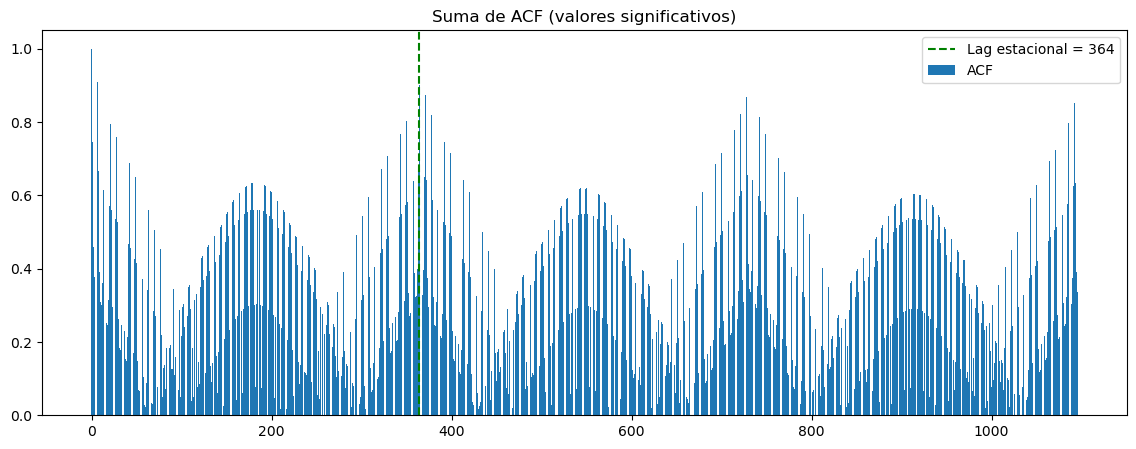

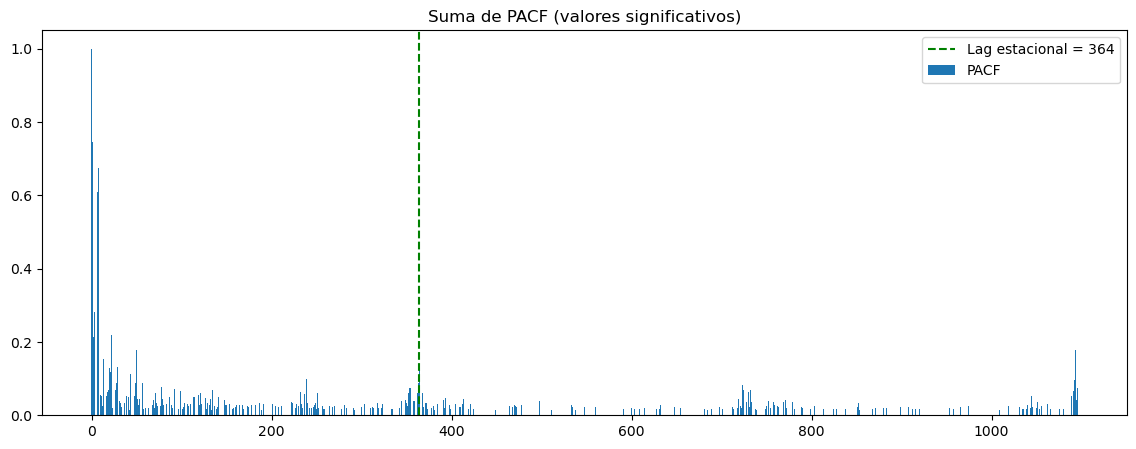

In [12]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir parámetros: mirar 3 años
max_lag = 365 * 3
PERIODO_ESTIMADO = 364

# Calcular ACF y PACF
acf_vals = acf(serie_GWh, nlags=max_lag)
pacf_vals = pacf(serie_GWh, nlags=max_lag, method='ywm')

# Calcular umbrales de significancia (95% CI)
conf_int = 1.96 / np.sqrt(len(serie_GWh))
significant_acf = np.where(np.abs(acf_vals) > conf_int, np.abs(acf_vals), 0)
significant_pacf = np.where(np.abs(pacf_vals) > conf_int, np.abs(pacf_vals), 0)

# Sumar por lag (para ranking)
acf_sum = pd.Series(significant_acf).sort_values(ascending=False)
pacf_sum = pd.Series(significant_pacf).sort_values(ascending=False)


# Mostrar top lags para p y q
print("Lags significativos en PACF (para p):", pacf_sum.head(10))
print()
print("Lags significativos en ACF (para q):", acf_sum.head(10))


# Graficar
plt.figure(figsize=(14,5))
plt.bar(range(len(significant_acf)), significant_acf, label="ACF")
plt.axvline(x=PERIODO_ESTIMADO, color='green', linestyle='--', label='Lag estacional = 364')
plt.title("Suma de ACF (valores significativos)")
plt.legend()
plt.show()

plt.figure(figsize=(14,5))
plt.bar(range(len(significant_pacf)), significant_pacf, label="PACF")
plt.axvline(x=PERIODO_ESTIMADO, color='green', linestyle='--', label='Lag estacional = 364')
plt.title("Suma de PACF (valores significativos)")
plt.legend()
plt.show()


### Descomposición
Está claro que hay una estacionalidad relacionada con el momento del año.

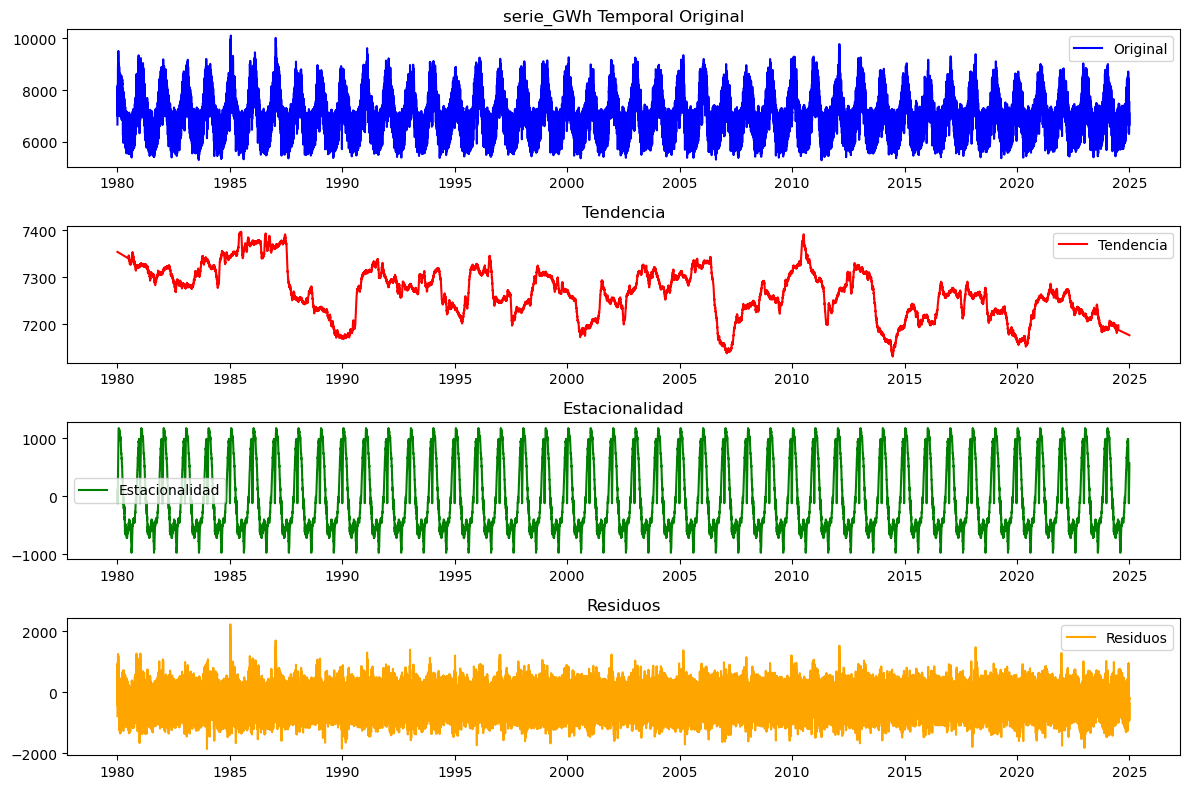

In [37]:
# ESTACIONALIDAD anual
PERIODO_ANUAL = 365

serie_GWh_descomp = seasonal_decompose(serie_GWh, model='additive', extrapolate_trend='freq', period=PERIODO_ANUAL)

# Obtención de las componentes
trend = serie_GWh_descomp.trend
seasonal = serie_GWh_descomp.seasonal
residuals = serie_GWh_descomp.resid

# Graficar las componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(serie_GWh, label='Original', color='blue')
plt.legend()
plt.title('serie_GWh Temporal Original')

plt.subplot(412)
plt.plot(trend, label='Tendencia', color='red')
plt.legend()
plt.title('Tendencia')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='green')
plt.legend()
plt.title('Estacionalidad')

plt.subplot(414)
plt.plot(residuals, label='Residuos', color='orange')
plt.legend()
plt.title('Residuos')

plt.tight_layout()
plt.show()

## FINDINGS
- ```d=0``` :  serie_GWh estacionaria según test ADF y KPSS
- ```D=0```
- ```m=364``` : Estacionalidad anual confirmada visual y numéricamente
- ```p``` : por el PACF vemos que los lags más significativos son ```[1, 6, 8]```
- ```q``` : por el ACF vemos que los lags más significativos son ```[7, 14]```
- ```P``` : en la gráfica del PACF vemos un pico relevante en $364$ por lo tanto ```P=1```
- ```Q``` : por el ACF vemos que los lags (estacionales $+364$) más significativos son $364, 371, 728$, por lo tanto ```Q~[1,2]```

